In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

/tmp/ipykernel_16478/4167336305.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Markdown, display, HTML


In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2

In [14]:
df = pd.read_csv(path.expanduser("/home/emanuele/Desktop/teb_runs/results.csv"))
with open(path.expanduser("/home/emanuele/Desktop/teb_runs/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)
    
df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
run_parameters += ['max_steering_angle_deg']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
#df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df['max_steering_angle_deg'] = 90    # crea una nuova colonna e riempie le righe con il valore 90
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']


min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    34

## Run Parameters

    amcl_alpha_factor                                                      [1.0]

    environment_name                                                       ['7A-2']

    global_planner_node                                                    ['global_planner']

    local_planner_node                                                     ['teb']

    localization_node                                                      ['amcl']

    max_samples                                                            [10, 20]

    min_turning_radius                                                     [0.01]

    pedestrian_max_vel                                                     [0.3]

    pedestrian_number                                                      [5]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    run_replication_index                                                  [0]

    beta_1                                                                 [0.01]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.01]

    beta_4                                                                 [0.0]

    max_steering_angle_deg                                                 [90]

## Metrics

    collision_rate                                                         min:          0             avg:          0             max:          0             nan:          0

    collision_time                                                         min:        nan             avg:        nan             max:        nan             nan:         34

    collision_rate_version                                                 [3]

    minimum_clearance                                                      min:    0.03564             avg:      0.179             max:     0.5827             nan:          0

    average_clearance                                                      min:     0.4151             avg:      1.212             max:      1.877             nan:          0

    median_clearance                                                       min:     0.1949             avg:      1.137             max:      2.153             nan:          0

    maximum_clearance                                                      min:      1.595             avg:      2.676             max:      3.293             nan:          0

    clearance_version                                                      [3]

    trajectory_length                                                      min:      4.993             avg:      36.38             max:      100.4             nan:          0

    trajectory_length_version                                              [1]

    execution_time                                                         min:       19.1             avg:      146.9             max:      388.9             nan:          0

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.7647             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   0.008122             avg:    0.09642             max:       1.35             nan:          0

    odometry_error_alpha_1_std                                             min:   0.005165             avg:     0.6459             max:      11.36             nan:          0

    odometry_error_alpha_2_mean                                            min:   0.003824             avg:     0.1872             max:      2.437             nan:          0

    odometry_error_alpha_2_std                                             min:    0.01219             avg:      1.261             max:      13.78             nan:          0

    odometry_error_alpha_3_mean                                            min:    0.01146             avg:    0.01542             max:    0.05611             nan:          0

    odometry_error_alpha_3_std                                             min:   0.001634             avg:    0.03402             max:     0.3466             nan:          0

    odometry_error_alpha_4_mean                                            min:    0.01901             avg:     0.0772             max:     0.2831             nan:          0

    odometry_error_alpha_4_std                                             min:    0.02799             avg:     0.1292             max:      2.271             nan:          0

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:    0.08004             avg:     0.5761             max:      3.603             nan:          0

    localization_update_absolute_translation_error_std                     min:    0.02154             avg:     0.6109             max:      4.861             nan:          0

    localization_update_absolute_rotation_error_mean                       min:   0.008922             avg:    0.04369             max:     0.2342             nan:          0

    localization_update_absolute_rotation_error_std                        min:   0.005869             avg:    0.05727             max:     0.2824             nan:          0

    localization_update_relative_translation_error_mean                    min:   0.009371             avg:    0.02763             max:     0.1154             nan:          0

    localization_update_relative_translation_error_std                     min:   0.005556             avg:     0.0776             max:      1.111             nan:          0

    localization_update_relative_rotation_error_mean                       min:   0.003594             avg:    0.01017             max:    0.07096             nan:          0

    localization_update_relative_rotation_error_std                        min:   0.002773             avg:    0.03447             max:     0.3906             nan:          0

    localization_update_normalized_relative_translation_error_mean         min:    0.06364             avg:      0.292             max:      1.504             nan:          0

    localization_update_normalized_relative_translation_error_std          min:    0.09204             avg:      1.336             max:      19.61             nan:          0

    localization_update_normalized_relative_rotation_error_mean            min:    0.03343             avg:      0.114             max:      1.009             nan:          0

    localization_update_normalized_relative_rotation_error_std             min:    0.02642             avg:     0.3046             max:      4.589             nan:          0

    localization_update_error_version                                      [4]

    absolute_translation_error                                             min:    0.08004             avg:     0.5761             max:      3.603             nan:          0

    collisionless_localization_update_absolute_translation_error_std       min:    0.02154             avg:     0.6109             max:      4.861             nan:          0

    absolute_rotation_error                                                min:   0.008922             avg:    0.04369             max:     0.2342             nan:          0

    collisionless_localization_update_absolute_rotation_error_std          min:   0.005869             avg:    0.05727             max:     0.2824             nan:          0

    collisionless_localization_update_relative_translation_error_mean      min:   0.009371             avg:    0.02763             max:     0.1154             nan:          0

    collisionless_localization_update_relative_translation_error_std       min:   0.005556             avg:     0.0776             max:      1.111             nan:          0

    collisionless_localization_update_relative_rotation_error_mean         min:   0.003594             avg:    0.01017             max:    0.07096             nan:          0

    collisionless_localization_update_relative_rotation_error_std          min:   0.002773             avg:    0.03447             max:     0.3906             nan:          0

    normalized_relative_translation_error                                  min:    0.06364             avg:      0.292             max:      1.504             nan:          0

    collisionless_localization_update_normalized_relative_translation_error_std min:    0.09204             avg:      1.336             max:      19.61             nan:          0

    normalized_relative_rotation_error                                     min:    0.06296             avg:     0.2405             max:      2.395             nan:          0

    collisionless_localization_update_normalized_relative_rotation_error_std min:    0.06489             avg:     0.9089             max:      18.91             nan:          0

    collisionless_localization_update_error_version                        [1]

    localization_update_rate                                               min:     0.6368             avg:     0.8803             max:      1.018             nan:          0

    localization_update_rate_std                                           min:     0.1633             avg:     0.3242             max:      1.502             nan:          0

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:     0.1685             avg:     0.2739             max:     0.3402             nan:          0

    average_rotation_velocity                                              min:    0.04231             avg:     0.1027             max:     0.2696             nan:          0

    translation_rotation_product                                           min:    0.01196             avg:    0.02889             max:     0.0836             nan:          0

    average_translation_acceleration                                       min:    0.02826             avg:    0.07007             max:     0.1455             nan:          0

    average_rotation_acceleration                                          min:    0.05755             avg:     0.1337             max:     0.2951             nan:          0

    translation_rotation_acceleration_product                              min:   0.005016             avg:    0.01642             max:    0.04473             nan:          0

    average_velocity_atan                                                  min:     0.1178             avg:     0.3144             max:     0.8326             nan:          0

    motion_characteristics_version                                         [4]

    move_base_cpu_time                                                     min:        2.6             avg:      17.95             max:      44.58             nan:          0

    simulation_cpu_time                                                    min:      67.11             avg:      372.4             max:      932.6             nan:          0

    system_cpu_time                                                        min:        8.1             avg:      38.27             max:      86.48             nan:          0

    move_base_max_memory                                                   min:          0             avg:          0             max:          0             nan:          0

    simulation_max_memory                                                  min:      574.2             avg:      585.6             max:      600.7             nan:          0

    system_max_memory                                                      min:      152.9             avg:      154.8             max:      163.2             nan:          0

    cpu_time_and_max_memory_version                                        [3]

    max_cmd_vel_translation                                                min:       0.26             avg:       0.26             max:       0.26             nan:          0

    max_cmd_vel_rotation                                                   min:     0.6381             avg:      0.942             max:          1             nan:          0

    mean_cmd_vel_translation                                               min:     0.1444             avg:     0.2455             max:     0.2597             nan:          0

    mean_cmd_vel_rotation                                                  min:   -0.04279             avg:    0.02248             max:     0.1119             nan:          0

    cmd_vel_metrics_version                                                [2]

    normalized_curvature                                                   min:   0.003459             avg:    0.01474             max:    0.07195             nan:          0

    normalized_curvature_version                                           [1]

    average_velocity                                                       min:     0.1483             avg:     0.2453             max:     0.2658             nan:          0

    norm_execution_time                                                    min:     0.5178             avg:     0.9535             max:      1.076             nan:          4

In [15]:
df[ (df.max_samples == 10)]

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time
1,session_2023-02-14_15-28-13_243746_run_000000001,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,1,90,7,7A-2_7,0.263,134.600,1.013
3,session_2023-02-14_15-28-13_243746_run_000000003,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,3,90,2,7A-2_2,0.256,19.097,1.021
10,session_2023-02-14_15-28-13_243746_run_000000010,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,10,90,1,7A-2_1,0.261,217.696,1.000
11,session_2023-02-14_15-28-13_243746_run_000000011,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,11,90,5,7A-2_5,0.261,114.539,1.000
14,session_2023-02-14_15-28-13_243746_run_000000014,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,14,90,14,7A-2_14,0.262,160.748,1.000
18,session_2023-02-14_15-28-13_243746_run_000000018,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,18,90,16,7A-2_16,0.258,141.349,1.000
20,session_2023-02-14_15-28-13_243746_run_000000020,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,20,90,8,7A-2_8,0.236,nan,nan
21,session_2023-02-14_15-28-13_243746_run_000000021,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,21,90,15,7A-2_15,0.148,nan,nan
22,session_2023-02-14_15-28-13_243746_run_000000022,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,22,90,0,7A-2_0,0.259,315.098,1.000
23,session_2023-02-14_15-28-13_243746_run_000000023,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,23,90,12,7A-2_12,0.259,145.598,1.000


In [17]:
df[ (df.max_samples == 20)]

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time
0,session_2023-02-14_15-28-13_243746_run_000000000,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,0,90,12,7A-2_12,0.258,145.598,1.005
2,session_2023-02-14_15-28-13_243746_run_000000002,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,2,90,2,7A-2_2,0.265,19.097,1.000
4,session_2023-02-14_15-28-13_243746_run_000000004,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,4,90,14,7A-2_14,0.261,160.748,1.013
5,session_2023-02-14_15-28-13_243746_run_000000005,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,5,90,5,7A-2_5,0.253,114.539,1.076
6,session_2023-02-14_15-28-13_243746_run_000000006,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,6,90,7,7A-2_7,0.266,134.600,1.000
7,session_2023-02-14_15-28-13_243746_run_000000007,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,7,90,1,7A-2_1,0.259,217.696,1.014
8,session_2023-02-14_15-28-13_243746_run_000000008,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,8,90,0,7A-2_0,0.228,315.098,0.559
9,session_2023-02-14_15-28-13_243746_run_000000009,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,9,90,6,7A-2_6,0.205,281.198,0.518
12,session_2023-02-14_15-28-13_243746_run_000000012,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,12,90,9,7A-2_9,0.250,44.649,1.048
13,session_2023-02-14_15-28-13_243746_run_000000013,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,13,90,3,7A-2_3,0.263,146.148,1.015


In [6]:
#df[df.norm_trajectory_length_std.isna()]['run_id']


In [7]:
np.nan == np.nan

False

In [18]:
df[['run_id', 'collision_rate']]

,run_id,collision_rate
0,session_2023-02-14_15-28-13_243746_run_000000000,0
1,session_2023-02-14_15-28-13_243746_run_000000001,0
2,session_2023-02-14_15-28-13_243746_run_000000002,0
3,session_2023-02-14_15-28-13_243746_run_000000003,0
4,session_2023-02-14_15-28-13_243746_run_000000004,0
5,session_2023-02-14_15-28-13_243746_run_000000005,0
6,session_2023-02-14_15-28-13_243746_run_000000006,0
7,session_2023-02-14_15-28-13_243746_run_000000007,0
8,session_2023-02-14_15-28-13_243746_run_000000008,0
...,...,...


In [7]:
# restituisce tutte le righe aventi arena e collision rate pari a 1. Ho splittato in 2 istruzioni come consigliato su stackoverflow, per evitare warning.
df2 = df[df.local_planner_node =='arena'] 
df2[df2.collision_rate == 1]

# scarta riga se c'è un nan nella metrica

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time


In [15]:
df[ (df.local_planner_node =='dwa') & (df.success_rate == 1) ] 

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,min_turning_radius,pedestrian_max_vel,pedestrian_number,robot_model,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time
1,session_2023-01-30_16-30-24_571759_run_000000001,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,1,90,14,intel_14,0.246,128.949,1.000
2,session_2023-01-30_16-30-24_571759_run_000000002,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,2,90,4,intel_4,0.245,352.050,1.000
3,session_2023-01-30_16-30-24_571759_run_000000003,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,3,90,5,intel_5,0.061,70.749,1.000
4,session_2023-01-30_16-30-24_571759_run_000000004,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,4,90,11,intel_11,0.192,47.594,1.000
5,session_2023-01-30_16-30-24_571759_run_000000005,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,5,90,3,intel_3,0.234,95.646,1.000
9,session_2023-01-30_16-30-24_571759_run_000000009,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,9,90,13,intel_13,0.077,60.198,1.000
10,session_2023-01-30_16-30-24_571759_run_000000010,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,10,90,10,intel_10,0.222,47.800,1.000
11,session_2023-01-30_16-30-24_571759_run_000000011,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,11,90,0,intel_0,0.233,77.598,1.000
12,session_2023-01-30_16-30-24_571759_run_000000012,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,12,90,7,intel_7,0.247,131.591,1.000
13,session_2023-01-30_16-30-24_571759_run_000000013,1.000,intel,global_planner,dwa,amcl,0.010,0.300,5,turtle,...,0.010,0.000,2023-01-30_16-30-24_571759,13,90,9,intel_9,0.158,172.190,1.000


In [11]:
len(df2[df2.collision_rate == 1]) #restituisce il numero di righe

0

In [12]:
# alternativa se non si vogliono considerare i null values
df2[df2.collision_rate == 1].count()

run_id                    0
amcl_alpha_factor         0
environment_name          0
global_planner_node       0
local_planner_node        0
localization_node         0
min_turning_radius        0
pedestrian_max_vel        0
pedestrian_number         0
robot_model               0
run_index                 0
run_replication_index     0
                         ..
beta_1                    0
beta_2                    0
beta_3                    0
beta_4                    0
session_id                0
run_number                0
max_steering_angle_deg    0
run_index_str             0
goal_index                0
average_velocity          0
min_execution_time        0
norm_execution_time       0
Length: 84, dtype: int64

In [13]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

KeyError: "Columns not found: 'norm_trajectory_length'"

In [ ]:
printmd("### Only considering successful runs (sorted by norm trajectory length)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_trajectory_length', 'mean'), ascending=True)

In [ ]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

## success rate

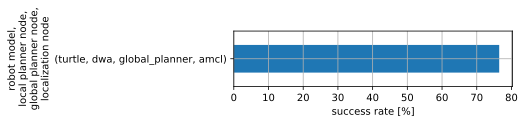

## collision_rate

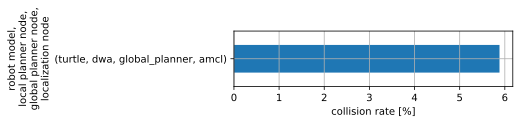

## average_velocity, only successful runs

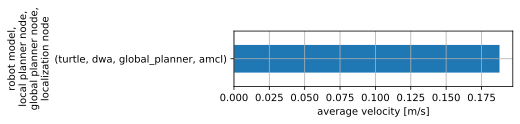

## norm_trajectory_length, only successful runs

KeyError: 'Column not found: norm_trajectory_length'

In [14]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner_node', 'global_planner_node', 'localization_node'], percentage=False, unit_symbol=None, higher_better=True):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([5, 1])
    plt.show()
printmd("## success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%')
printmd("## collision_rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%')
printmd("## average_velocity, only successful runs")
bar_plot(metric_name='average_velocity', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m/s')
printmd("## norm_trajectory_length, only successful runs")
bar_plot(metric_name='norm_trajectory_length', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m/m')
printmd("## norm_execution_time, only successful runs")
bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s')

In [ ]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


In [ ]:
printmd("## Localization perf from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.average_velocity, 0.02], 
    [d.average_translation_velocity, 0.02], 
    #[d.average_velocity_atan, 0.1],
    [d.beta_1, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )


printmd("## Localization perf from own parameters")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.amcl_alpha_factor, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )

In [ ]:
# printmd("## avg vel and avg vel atan are similar")
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics = [
#     d.average_translation_velocity,
#     d.average_rotation_velocity,
#     d.average_velocity_atan,
# ]
# bin_widths = [0.02, 0.05, 0.1]
# min_bin_count = 10
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_translation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_rotation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity_atan, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )

In [ ]:

# print(df.goal_index)

bin_widths = [None, None, None]
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics = [
    d.environment_name,
    d.run_duplicate_index,
    d.goal_index,
]

plot_in_out_metrics_bin_width_save(
    output_metric=d.minimum_clearance, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:

# printmd("### norm trajectory length ← absolute translation error doesn't work because when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.01]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.absolute_translation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
    
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:

# printmd("### norm trajectory length, trajectory length ← other localization error metrics")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.03]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.normalized_relative_rotation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:


for e in df.environment_name.unique():
    printmd(f"## {e}")
    min_bin_count = 10
    d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
    bin_widths = [1, .1, .01]
    input_metrics = [
        d.maximum_clearance, 
        d.average_clearance, 
        d.minimum_clearance, 
    ]
    plot_in_out_metrics_bin_width_save(
        output_metric=d.average_velocity, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=True,
        out_dir=f"thesis_plots/local_planner/{e}",
    )


In [ ]:

printmd("## Local Planning perf (also system features)")

min_bin_count = 10
d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity_atan, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
## plots_local_planner

printmd("## Local Planning perf (not system features)")

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collision_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_trajectory_length, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_execution_time, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
# ## plots_local_planner

# min_bin_count = 10

# d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics, bin_widths = zip(*[
# #     [d.beta_1, None], 
# #     [d.amcl_alpha_factor, None],
# #     [d.minimum_clearance, .1],
# #     [d.average_clearance, 1],
#     [d.absolute_translation_error, 0.05],
#     [d.absolute_rotation_error, 0.01],
#     [d.normalized_relative_translation_error, 0.05],
#     [d.normalized_relative_rotation_error, 0.05],
# ])

# printmd("## norm_trajectory_length")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_std")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_std, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_mean")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_mean, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_median")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_median, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )

In [ ]:
df_s = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()

bins = np.arange(df_s.trajectory_length.min(), df_s.trajectory_length.max(), 5)
df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('absolute_translation_error')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 